In [1]:
import numpy as np
import pandas as pd

import os
import sys
import json
from pathlib import Path
import gc
import inspect
import random
import time

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

from copy import deepcopy
from copy import copy

from tqdm.notebook import tqdm

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import torch

In [3]:
sys.path.insert(0, '..')
sys.path.insert(0, '../DSL')

from visualization.visualization_utils import *
import solvers
from solver_class import Solver
from dsl import *
from constants import *
from fitness_scoring import *

In [4]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'

In [5]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)
with open(eval_path, 'r') as f:
    eval_tasks = json.load(f)
with open(eval_sols_path, 'r') as f:
    eval_sols = json.load(f)

train_task_labels = sorted(train_tasks.keys())
eval_task_labels = sorted(eval_tasks.keys())

In [6]:
ast = lambda g: tuple(tuple(r) for r in g) # Converts grid to tuple format for DSL

# Convert all train and eval examples to tuples for DSL
for train_label in train_task_labels:
    num_train = len(train_tasks[train_label]['train']) 
    num_test = len(train_tasks[train_label]['test'])
    for i in range(num_train):
        train_tasks[train_label]['train'][i]['input'] = ast(train_tasks[train_label]['train'][i]['input'])
        train_tasks[train_label]['train'][i]['output'] = ast(train_tasks[train_label]['train'][i]['output'])
    for i in range(num_test):
        train_tasks[train_label]['test'][i]['input'] = ast(train_tasks[train_label]['test'][i]['input'])
        train_sols[train_label][i] = ast(train_sols[train_label][i])
for eval_label in eval_task_labels:
    num_train = len(eval_tasks[eval_label]['train']) 
    num_test = len(eval_tasks[eval_label]['test'])
    for i in range(num_train):
        eval_tasks[eval_label]['train'][i]['input'] = ast(eval_tasks[eval_label]['train'][i]['input'])
        eval_tasks[eval_label]['train'][i]['output'] = ast(eval_tasks[eval_label]['train'][i]['output'])
    for i in range(num_test):
        eval_tasks[eval_label]['test'][i]['input'] = ast(eval_tasks[eval_label]['test'][i]['input'])
        eval_sols[eval_label][i] = ast(eval_sols[eval_label][i])

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


# Load pretrained model

In [8]:
codegen_tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                                 padding_side='left', # For padding batches of input in decoder-only context
                                                 clean_up_tokenization_spaces = True,
                                                 #torch_dtype=torch.float16, # For quantization; TODO figure out how this works
                                                 ) 
codegen = AutoModelForCausalLM.from_pretrained("../CodeGen fine-tuning/outputs/v7/",
                                              #torch_dtype=torch.float16, # For quantization; TODO figure out how this works
                                              )
codegen = codegen.to(DEVICE)

In [9]:
EOS_TOKEN = codegen_tokenizer.eos_token
BOS_TOKEN = codegen_tokenizer.bos_token
PAD_TOKEN = '[PAD]'
codegen_tokenizer.add_special_tokens({'pad_token': PAD_TOKEN})
#codegen_tokenizer.pad_token = codegen_tokenizer.eos_token

1

# Helper functions

In [10]:
def grid_to_string(grid):
    """
    Simply converts grid to string and removes whitespace.
    A 30-by-30 grid will use ~1800 tokens.
    """
    return str(grid).replace(" ", "")

def grid_to_string_compact(grid):
    """
    Rows as strings of characters separated by linebreaks.
    Uses approximately 4-times fewer tokens than grid_to_string.
    """
    return "\n".join(["".join([str(entry) for entry in row]) for row in grid])

In [11]:
def create_generation_prompt(in_grid, out_grid, name = 'solve'):
    result = f'''def {name}(I):
    """
    INPUT:
    {"\n    ".join(grid_to_string_compact(in_grid).split("\n"))}
    OUTPUT:
    {"\n    ".join(grid_to_string_compact(out_grid).split("\n"))}
    """
    '''
    return result

In [12]:
def random_label() -> str:
    """
    Random task label consisting of 8 hexidecimal digits lowercase.
    """
    digits = list("0123456789abcdef")
    return "".join([random.choice(digits) for _ in range(8)])

In [13]:
def random_grid(rows = None, cols = None, palette = None):
    if not rows:
        rows = random.randint(1,30)
    if not cols:
        cols = random.randint(1,30)
    if not palette:
        palette = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    return tuple(tuple(random.choice(palette) for _ in range(cols)) for _ in range(rows))

In [14]:
def generate_candidate_solvers(model,
                               tokenizer,
                               in_out_pairs,
                               generate_args = {
                                   'max_new_tokens': 512, 
                                   'do_sample': True,
                                   'temperature': 2.0,
                                   'top_k': 50,
                               },
                               min_num_solvers = 512,
                               batch_size = 16,
                              ):
    candidates = []
    prompts = []

    while len(prompts) < min_num_solvers:
        prompts.extend([create_generation_prompt(pair['input'], pair['output']) for pair in in_out_pairs])
    
    for i in range((len(prompts)-1) // batch_size + 1):  
        inputs = tokenizer(prompts[i*batch_size : (i+1)*batch_size],
                           padding = True,
                           return_tensors = 'pt',
                          ).to(DEVICE)
        outputs = model.generate(**inputs,
                                 pad_token_id = tokenizer.pad_token_id,
                                **generate_args,
                                )

        candidates.extend(tokenizer.batch_decode(outputs))

    return candidates
        

In [15]:
def clean_candidate(candidate: str) -> str:
    candidate = candidate.replace(EOS_TOKEN, "")
    candidate = candidate.replace(BOS_TOKEN, "")
    candidate = candidate.replace(PAD_TOKEN, "")
    if "return O" not in candidate:
        return None
    return candidate.split("return O")[0] + "return O"


def clean_candidates(candidates: list[str]) -> [int, list[str]]:
    num_failed = 0
    cleaned = []
    for c in candidates:
        c_cleaned = clean_candidate(c)
        if c_cleaned:
            cleaned.append(c_cleaned)
        else:
            num_failed += 1
    return num_failed, cleaned            

In [16]:
def compile_candidates(candidates: list[str]) -> [int, list[Solver]]:
    num_failed = 0
    compiled = []
    for c in candidates:
        try:
            compiled.append(Solver(c))
        except:
            num_failed += 1
    return num_failed, compiled

In [17]:
# Got OOM on iteration 60/400 using batchsize 32, after 5hr 30min, 1000 progs per task
MAX_BATCH_SIZE = 16

# Generate solvers

# Scratch work

In [39]:
#l = random.choice(eval_task_labels)
l = 'cad67732'
print(l)

cad67732


In [40]:
pairs = eval_tasks[l]['train']

In [41]:
candidates = generate_candidate_solvers(codegen, codegen_tokenizer, pairs, min_num_solvers = 256)

In [42]:
cleaning_failed, cleaned = clean_candidates(candidates)
print(f"{cleaning_failed} candidates failed to clean, out of {len(candidates)}")

22 candidates failed to clean, out of 258


In [43]:
print(f"We have {len(cleaned)} candidates before deduplication")
# CAREFUL! This dedup doesn't account for the fact that the same solver can show up multiple times 
# with different docstrings
cleaned = list(set(cleaned))
print(f"We have {len(cleaned)} candidates after deduplication")

We have 236 candidates before deduplication
We have 150 candidates after deduplication


In [44]:
compile_failed, solvers = compile_candidates(cleaned)
print(f"{compile_failed} candidates failed to compile, out of {len(cleaned)}")

35 candidates failed to compile, out of 150


In [45]:
%env TOKENIZERS_PARALLELISM true

env: TOKENIZERS_PARALLELISM=true


In [46]:
scored = score_solvers_vs_tasks(solvers, pairs, scoring_functions = scoring_functions)
scored = sorted(scored, key = lambda x: x[0])

In [47]:
print(len(scored))

115


In [48]:
scored[0][1].function_text == scored[1][1].function_text

True

In [49]:
score_successfully = [(score, solver) for score, solver in scored if score < 1.0]
print(len(score_successfully))

31


In [50]:
for score, _ in score_successfully:
    print(score)

0.1391524960152411
0.1391524960152411
0.1391524960152411
0.20014358468495638
0.2300116326440139
0.29653021442495126
0.29653021442495126
0.29653021442495126
0.35987507388128126
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36838574423480086
0.3796248196248196
0.404058229352347
0.4129712457564807
0.4271206243696129
0.43226495726495723
0.44763469592117455
0.46580620541873374
0.46703346699165865
0.4814426877470355
0.4949381982854942
0.5215342367813851
0.5307662105032893
0.5451111111111111
0.6211790585196206
0.6574048531289911
0.8233333333333333


In [51]:
print(sum(score for score, _ in score_successfully)/len(score_successfully))

0.400583617460636


In [52]:
scores_each_generation = []
generation = 1

while True:
    print("")
    print(f"Starting generation {generation}")
    generation += 1
    
    new_prompts = []
    for score, solver in score_successfully[:len(score_successfully)//2]:
        for k in range(solver.num_lines()+1):
            new_prompts.append(solver.without_last_k_lines(k))
    new_prompts = random.sample(new_prompts, min(512, len(new_prompts)))

    new_candidates = []
    batch_size = 32
    generate_args = {
       'max_new_tokens': 512, 
       'do_sample': True,
       'temperature': 3.0,
       'top_k': 50,
    }
    for i in range((len(new_prompts)-1) // batch_size + 1):  
        inputs = codegen_tokenizer(new_prompts[i*batch_size : (i+1)*batch_size],
                           padding = True,
                           return_tensors = 'pt',
                          ).to(DEVICE)
        try:
            outputs = codegen.generate(**inputs,
                                     pad_token_id = codegen_tokenizer.pad_token_id,
                                    **generate_args,
                                    )
        except:
            outputs = []
    
        new_candidates.extend(codegen_tokenizer.batch_decode(outputs))

    if len(new_candidates) == 0:
        break
    
    cleaning_failed, cleaned = clean_candidates(new_candidates)
    print(f"{cleaning_failed} candidates failed to clean, out of {len(new_candidates)}")
    
    #print(f"We have {len(cleaned)} candidates before deduplication")
    # CAREFUL! This dedup doesn't account for the fact that the same solver can show up multiple times 
    # with different docstrings
    cleaned = list(set(cleaned))
    print(f"We have {len(cleaned)} candidates after deduplication")

    compile_failed, solvers = compile_candidates(cleaned)
    print(f"{compile_failed} candidates failed to compile, out of {len(cleaned)}")\

    scored = score_solvers_vs_tasks(solvers,
                                    pairs,
                                    scoring_functions = scoring_functions)
    scored = sorted(scored, key = lambda x: x[0])

    score_successfully = [(score, solver) for score, solver in scored if score < 1.0]
    print(f"{len(score_successfully)} scored out of {len(scored)}")

    print(f"Best score: {scored[0][0]}")
    
    scores_each_generation.append(score_successfully)


Starting generation 1
23 candidates failed to clean, out of 266
We have 148 candidates after deduplication
57 candidates failed to compile, out of 148
26 scored out of 91
Best score: 0.1391524960152411

Starting generation 2
25 candidates failed to clean, out of 255
We have 150 candidates after deduplication
36 candidates failed to compile, out of 150
27 scored out of 114
Best score: 0.12106184159585957

Starting generation 3
13 candidates failed to clean, out of 177
We have 99 candidates after deduplication
37 candidates failed to compile, out of 99
24 scored out of 62
Best score: 0.12106184159585957

Starting generation 4
18 candidates failed to clean, out of 198
We have 103 candidates after deduplication
42 candidates failed to compile, out of 103
20 scored out of 61
Best score: 0.10612326612326613

Starting generation 5
18 candidates failed to clean, out of 160
We have 80 candidates after deduplication
26 candidates failed to compile, out of 80
21 scored out of 54
Best score: 0.12

In [53]:
torch.cuda.empty_cache()

In [54]:
just_scores = [ [score for score, _ in gen_results] for gen_results in scores_each_generation]

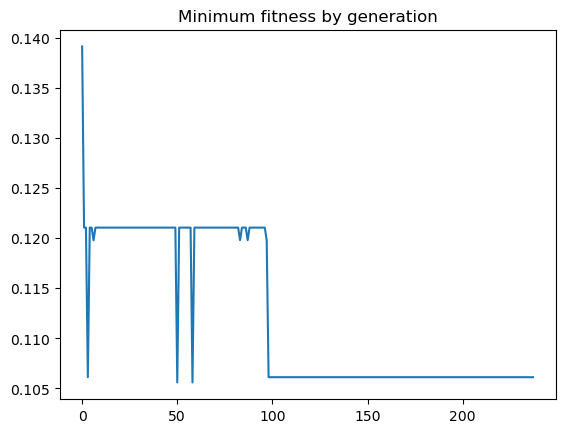

In [59]:
plt.plot([min(gen) for gen in just_scores])
plt.title("Minimum fitness by generation")
plt.show()

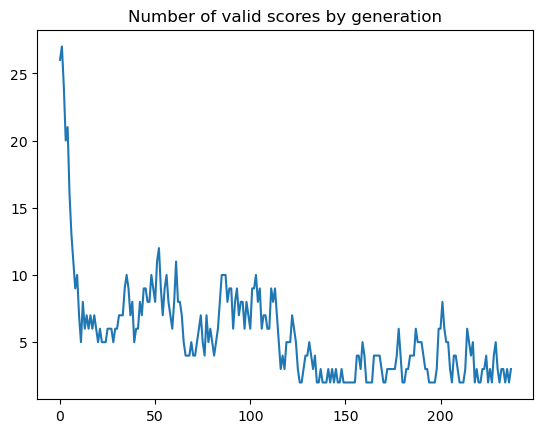

In [60]:
plt.plot([len(gen) for gen in just_scores])
plt.title("Number of valid scores by generation")
plt.show()

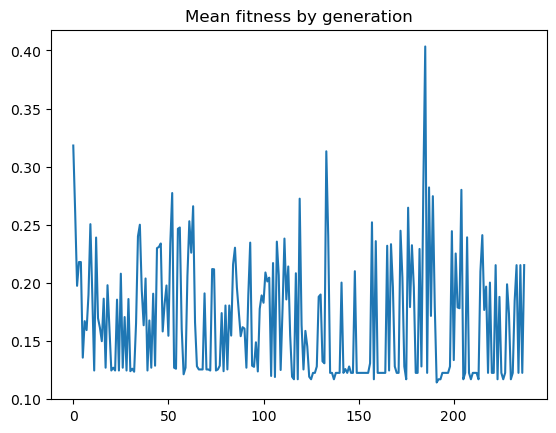

In [61]:
plt.plot([sum(gen)/len(gen) for gen in just_scores])
plt.title("Mean fitness by generation")
plt.show()

One solver that got a score of 0.1391524960152411
def solve(I):
    x1 = asobject(I)
    x2 = mostcolor(I)
    x3 = matcher(first, x2)
    x4 = compose(flip, x3)
    x5 = sfilter(x1, x4)
    x6 = apply(initset, x5)
    x7 = rbind(shoot, UNITY)
    x8 = compose(x7, center)
    x9 = fork(recolor, color, x8)
    x10 = mapply(x9, x6)
    x11 = shape(I)
    x12 = double(x11)
    x13 = mostcolor(I)
    x14 = canvas(x13, x12)
    O = paint(x14, x10)
    return O
Expected grids


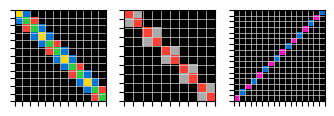

Actual grids:


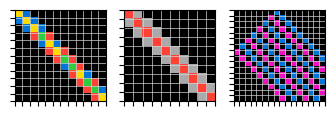

In [83]:
print(f"One solver that got a score of {scores_each_generation[0][0][0]}")
S0 = scores_each_generation[0][0][1]
print(S0.function_text)
print("Expected grids")
show_grids([pair['output'] for pair in pairs])
print("Actual grids:")
show_grids(list(map(S0, [pair['input'] for pair in pairs])))

One solver that got a score of 0.12106184159585957
def solve(I):
    x1 = asobject(I)
    x2 = mostcolor(I)
    x3 = matcher(first, x2)
    x4 = compose(flip, x3)
    x5 = sfilter(x1, x4)
    x6 = apply(initset, x5)
    x7 = rbind(shoot, UNITY)
    x8 = compose(x7, shape)
    x9 = fork(recolor, color, x8)
    x10 = mapply(x9, x6)
    x11 = shape(I)
    x12 = double(x11)
    x13 = mostcolor(I)
    x14 = canvas(x13, x12)
    O = paint(x14, x10)
    return O
Expected grids


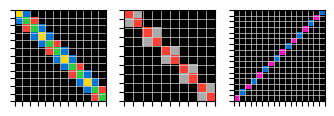

Actual grids:


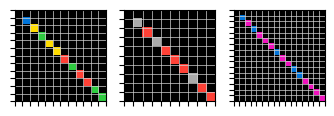

In [82]:
print(f"One solver that got a score of {scores_each_generation[2][0][0]}")
S1 = scores_each_generation[2][0][1]
print(S1.function_text)
print("Expected grids")
show_grids([pair['output'] for pair in pairs])
print("Actual grids:")
show_grids(list(map(S1, [pair['input'] for pair in pairs])))

One solver that got a score of 0.10559514309595752
def solve(I):
    x1 = asobject(I)
    x2 = mostcolor(I)
    x3 = matcher(first, x2)
    x4 = compose(flip, x3)
    x5 = sfilter(x1, x4)
    x6 = apply(initset, x5)
    x7 = rbind(shoot, UNITY)
    x8 = compose(x7, shape)
    x9 = fork(recolor, mostcolor, x8)
    x10 = mapply(x9, x6)
    x11 = shape(I)
    x12 = double(x11)
    x13 = mostcolor(I)
    x14 = canvas( x13, x12)
    x15 = paint(x14, x10)
    x16 = normalize(x5)
    O = paint(x15, x16)
    return O
Expected grids


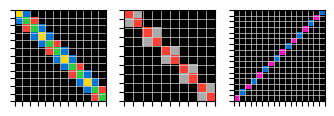

Actual grids:


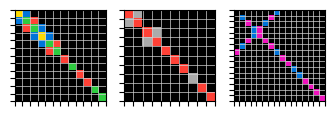

In [84]:
print(f"One solver that got a score of {scores_each_generation[50][0][0]}")
S2 = scores_each_generation[50][0][1]
print(S2.function_text)
print("Expected grids")
show_grids([pair['output'] for pair in pairs])
print("Actual grids:")
show_grids(list(map(S2, [pair['input'] for pair in pairs])))

One solver that got a score of 0.10612326612326613
def solve(I):
    x1 = asobject(I)
    x2 = mostcolor(I)
    x3 = matcher(first, x2)
    x4 = compose(flip, x3)
    x5 = sfilter(x1, x4)
    x6 = apply(initset, x5)
    x7 = rbind(shoot, UNITY)
    x8 = compose(x7, center)
    x9 = fork(recolor, color, x8)
    x10 = mfilter(x6, x9)
    x11 = shape(I)
    x12 = double(x11)
    x13 = mostcolor(I)
    x14 = canvas(x13, x12)
    O = paint(x14, x10)
    return O
Input grids:


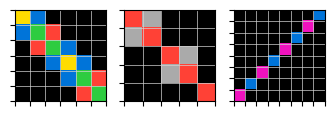

Expected grids


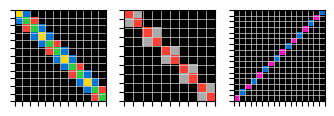

Actual grids:


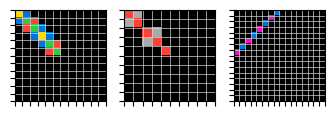

In [86]:
print(f"One solver that got a score of {scores_each_generation[-1][0][0]}")
S3 = scores_each_generation[-1][0][1]
print(S3.function_text)
print("Input grids:")
show_grids([pair['input'] for pair in pairs])
print("Expected grids")
show_grids([pair['output'] for pair in pairs])
print("Actual grids:")
show_grids(list(map(S3, [pair['input'] for pair in pairs])))

In [36]:
print([min(gen) for gen in just_scores])
print([len(gen) for gen in just_scores])
print([f"{sum(gen)/len(gen):.2f}" for gen in just_scores])

[0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411, 0.1391524960152411]
[15, 13, 9, 8, 9, 7, 11, 12, 9, 10, 9, 9, 8, 6, 9, 7, 7, 8, 7, 5]
['0.24', '0.25', '0.18', '0.18', '0.20', '0.22', '0.28', '0.27', '0.21', '0.18', '0.17', '0.18', '0.22', '0.14', '0.20', '0.14', '0.18', '0.14', '0.21', '0.21']


In [96]:
#del outputs
#del inputs
#del _80
torch.cuda.empty_cache()

In [60]:
new_prompts = []
for score, solver in score_successfully:
    for k in range(solver.num_lines()+1):
        new_prompts.append(solver.without_last_k_lines(k))
print(len(new_prompts))
new_prompts = random.sample(new_prompts, 256)

1208


In [61]:
new_candidates = []
batch_size = 32
generate_args = {
   'max_new_tokens': 512, 
   'do_sample': True,
   'temperature': 2.0,
   'top_k': 50,
}
for i in tqdm(range((len(new_prompts)-1) // batch_size + 1)):  
    inputs = codegen_tokenizer(new_prompts[i*batch_size : (i+1)*batch_size],
                       padding = True,
                       return_tensors = 'pt',
                      ).to(DEVICE)
    outputs = codegen.generate(**inputs,
                             pad_token_id = codegen_tokenizer.pad_token_id,
                            **generate_args,
                            )

    new_candidates.extend(codegen_tokenizer.batch_decode(outputs))


  0%|          | 0/8 [00:00<?, ?it/s]

In [62]:
cleaning_failed, cleaned = clean_candidates(new_candidates)
print(f"{cleaning_failed} candidates failed to clean, out of {len(new_candidates)}")

7 candidates failed to clean, out of 256


In [63]:
print(f"We have {len(cleaned)} candidates before deduplication")
# CAREFUL! This dedup doesn't account for the fact that the same solver can show up multiple times 
# with different docstrings
cleaned = list(set(cleaned))
print(f"We have {len(cleaned)} candidates after deduplication")

We have 249 candidates before deduplication
We have 102 candidates after deduplication


In [64]:
compile_failed, solvers = compile_candidates(cleaned)
print(f"{compile_failed} candidates failed to compile, out of {len(cleaned)}")

17 candidates failed to compile, out of 102


In [65]:
scored = score_solvers_vs_tasks(solvers, pairs, scoring_functions = scoring_functions)
scored = sorted(scored, key = lambda x: x[0])

In [66]:
score_successfully = [(score, solver) for score, solver in scored if score < 1.0]
print(len(score_successfully))

56


In [67]:
for score, _ in score_successfully:
    print(score)

0.1391524960152411
0.1391524960152411
0.1391524960152411
0.1391524960152411
0.1391524960152411
0.20014358468495638
0.20014358468495638
0.29653021442495126
0.29653021442495126
0.29653021442495126
0.29653021442495126
0.29653021442495126
0.34389486763506194
0.3543656839671332
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.36808080808080806
0.37454677493893174
0.4129712457564807
0.4271206243696129
0.43226495726495723
0.43226495726495723
0.44130848717055615
0.4419806583069364
0.4419806583069364
0.44763469592117455
0.44763469592117455
0.4481807994818962
0.48139692968862996
0.48947035090959146
0.49373246953418315
0.4949381982854942
0.4964141414141414
0.4964141414141414
0.49660998627784525
0.5322166105499438
0.5336190546552187
0.5464954175955324
0.5484773278354793
0.5484773278354793
0.6133859859113475
0.6484051479730116
0.6927628757535299
0.

In [68]:
print(sum(score for score, _ in score_successfully)/len(score_successfully))

0.4237768005824754
